In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [2]:

class Stem(torch.nn.Module):
    def __init__(self,in_channels=3,out_channels=32):
        super().__init__()
        self.layer = torch.nn.Sequential(*[
            torch.nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                     kernel_size=(3,3),stride=1,padding=1
                                 ),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(in_channels=out_channels,
                                      out_channels=out_channels,
                                     kernel_size=(3,3),stride=1,padding=1
                                 )
        ])
        
        self.shortcut = torch.nn.Sequential(*[
            torch.nn.Conv2d(in_channels=in_channels,
                           out_channels=out_channels,
                           kernel_size=(1,1),
                           stride=1),
            torch.nn.BatchNorm2d(out_channels)
        ])
        
    def forward(self,x):
        shortcut = self.shortcut(x)
        x = self.layer(x)
        return x + shortcut
        

class ResConvBlock(torch.nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.layer = torch.nn.Sequential(*[
            torch.nn.Conv2d(in_channels=in_channels,
                            out_channels=out_channels,
                            kernel_size=(3,3),stride=1,padding=1
                                 ),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(in_channels=out_channels,
                            out_channels=out_channels,
                            kernel_size=(3,3),stride=1,padding=1
                                 ),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(True),
        ])
        self.shortcut = torch.nn.Sequential(*[
            torch.nn.Conv2d(in_channels=in_channels,
                           out_channels=out_channels,
                           kernel_size=(1,1),stride=1),
            torch.nn.BatchNorm2d(out_channels)
        ])
    def forward(self,x):
        shortcut = self.shortcut(x)
        x = self.layer(x)
        return x + shortcut
    


class IntertwinedUNet(torch.nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.n_features = [32,64,128,256,512]
        self.downsample = torch.nn.MaxPool2d(2)
        self.upsample = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
                
        self.rgbStem = Stem(3,self.n_features[0])
        self.thrStem = Stem(3,self.n_features[0])
        
        self.rgbLayer1 = ResConvBlock(self.n_features[0],self.n_features[1])
        self.thrLayer1 = ResConvBlock(self.n_features[0],self.n_features[1])
        
        self.rgbLayer2 = ResConvBlock(self.n_features[1],self.n_features[2])
        self.thrLayer2 = ResConvBlock(self.n_features[1],self.n_features[2])
        
        self.rgbLayer3 = ResConvBlock(self.n_features[2],self.n_features[3])
        self.thrLayer3 = ResConvBlock(self.n_features[2],self.n_features[3])
        
        self.rgbLayer4 = ResConvBlock(self.n_features[3],self.n_features[4])
        self.thrLayer4 = ResConvBlock(self.n_features[3],self.n_features[4])
        
        self.bridge = ResConvBlock(self.n_features[4],self.n_features[4])
        
        self.dLayer4 = ResConvBlock(self.n_features[4]+self.n_features[3],self.n_features[3])
        self.dLayer3 = ResConvBlock(self.n_features[3]+self.n_features[2],self.n_features[2])
        self.dLayer2 = ResConvBlock(self.n_features[2]+self.n_features[1],self.n_features[1])
        self.dLayer1 = ResConvBlock(self.n_features[1]+self.n_features[0],self.n_features[0])
        
        self.out = torch.nn.Conv2d(self.n_features[0],n_class,1)
        
    def forward(self, rgb, thr):
        rgbStem = self.rgbStem(rgb)  # 256 
        rgb = self.downsample(rgbStem) # 128
        rgbLayer1 = self.rgbLayer1(rgb)
        rgb = self.downsample(rgbLayer1) # 64 
        rgbLayer2 = self.rgbLayer2(rgb)
        rgb = self.downsample(rgbLayer2) # 32 
        rgbLayer3 = self.rgbLayer3(rgb)
        rgb = self.downsample(rgbLayer3) # 16
        rgbLayer4 = self.rgbLayer4(rgb)
        
        thrStem = self.thrStem(thr)
        thr = self.downsample(thrStem)
        thrLayer1 = self.thrLayer1(thr)
        thr = self.downsample(thrLayer1)
        thrLayer2 = self.thrLayer2(thr)
        thr = self.downsample(thrLayer2)
        thrLayer3 = self.thrLayer3(thr)
        thr = self.downsample(thrLayer3)
        thrLayer4 = self.thrLayer4(thr)
        
        sumStem = rgbStem + thrStem  # 
        sumLayer1 = rgbLayer1 + thrLayer1  # 
        sumLayer2 = rgbLayer2 + thrLayer2  # 
        sumLayer3 = rgbLayer3 + thrLayer3  # 
        sumLayer4 = rgbLayer4 + thrLayer4  # 
        
        x = self.upsample(sumLayer4)
        x = torch.cat([x,sumLayer3],dim=1)
        x = self.dLayer4(x)
        x = self.upsample(x)
        x = torch.cat([x,sumLayer2],dim=1)
        x = self.dLayer3(x)
        x = self.upsample(x)
        x = torch.cat([x,sumLayer1],dim=1)
        x = self.dLayer2(x)
        x = self.upsample(x)
        x = torch.cat([x,sumStem],dim=1)
        x = self.dLayer1(x)
        out = self.out(x)
        
        return out
        
        


In [3]:
model = IntertwinedUNet(1)
zeros = torch.zeros(size=(1,3,256,256))
ones = torch.ones(size=(1,3,256,256))
out = model(zeros,ones)
out.shape

torch.Size([1, 1, 256, 256])

In [4]:
!ls datadir

 jungjaRGB10_0204DJI_0055	   jungjaRGB6_122_0205DJI_0057
 jungjaRGB2_190-2		   jungjaRGB7_197_0206DJI_0013
 jungjaRGB3_93-1		   jungjaRGB8_198_0204DJI_0088
'jungjaRGB4_102(2)_0205DJI_0031'   jungjaRGB9_210-1DJI_0071
 jungjaRGB5_102_0205DJI_0021	   soonaeRGB1_68-1


In [5]:
datadirs = os.listdir('./datadir/')
rgbPaths = []
thrPaths = []
labPaths = []

for datadir in datadirs:
    rgbs = [img for img in os.listdir('./datadir/'+datadir) if 'RGB' in img]
    labs = []
    thrs = []
    for rgb in rgbs:
        labs.append(rgb.replace('RGB','LAB'))
    for rgb in rgbs:
        thrs.append(rgb.replace('RGB','THR'))
        
    rgbs = ['./datadir/'+datadir+'/'+img for img in rgbs]
    labs = ['./datadir/'+datadir+'/'+img for img in labs]
    thrs = ['./datadir/'+datadir+'/'+img for img in thrs]
    
    rgbPaths += rgbs
    thrPaths += thrs
    labPaths += labs
    

rgbPaths[:3],labPaths[:3],thrPaths[:3]
    

(['./datadir/jungjaRGB3_93-1/RGB90.png',
  './datadir/jungjaRGB3_93-1/RGB122.png',
  './datadir/jungjaRGB3_93-1/RGB18.png'],
 ['./datadir/jungjaRGB3_93-1/LAB90.png',
  './datadir/jungjaRGB3_93-1/LAB122.png',
  './datadir/jungjaRGB3_93-1/LAB18.png'],
 ['./datadir/jungjaRGB3_93-1/THR90.png',
  './datadir/jungjaRGB3_93-1/THR122.png',
  './datadir/jungjaRGB3_93-1/THR18.png'])

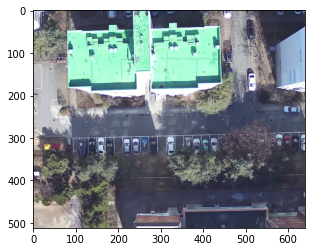

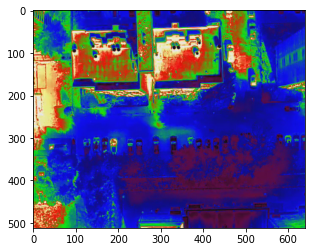

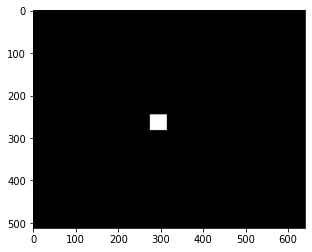

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
rgb = Image.open(rgbs[0])
thr = Image.open(thrs[0])
lab = Image.open(labs[0])
plt.imshow(rgb)
plt.show()
plt.imshow(thr)
plt.show()
plt.imshow(lab)
plt.show()

In [7]:
import numpy as np
img = np.array(lab)
img

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [8]:
from sklearn.model_selection import train_test_split
rgb_train,rgb_test, thr_train, thr_test, lab_train, lab_test = train_test_split(rgbPaths,thrPaths,labPaths,test_size=0.2,random_state=42)
len(rgb_train),len(thr_train),len(lab_train),len(rgb_test),len(thr_test),len(lab_test)

(3686, 3686, 3686, 922, 922, 922)

In [19]:
np_rgb, np_thr, np_lab = np.array(rgb_test),np.array(thr_test),np.array(lab_test)

In [20]:
np.save('./rgb_files.npy',np_rgb),np.save('./thr_files.npy',np_thr),np.save('./lab_files.npy',np_lab)

(None, None, None)

In [9]:
labimg = Image.open(lab_train[100]).convert('L')
npimg = np.array(labimg)
npimg.shape

(512, 640)

In [10]:
from torchvision import transforms
from PIL import Image

trans = transforms.Compose([
    transforms.ToTensor(),
])


class RGBTHRDataset(torch.utils.data.Dataset):
    def __init__(self,rgbList,thrList,labList,transform = trans):
        self.rgbList = rgbList
        self.thrList = thrList
        self.labList = labList
        self.transform = transform
        
    def __len__(self):
        return len(self.rgbList)
    
    def __getitem__(self,idx):
        rgb = Image.open(self.rgbList[idx])
        thr = Image.open(self.thrList[idx])
        lab = Image.open(self.labList[idx]).convert('L')
        
        if self.transform:
            rgb = self.transform(rgb)
            thr = self.transform(thr)
            lab = self.transform(lab)
            
        return rgb,thr,lab

In [11]:
trainDataset = RGBTHRDataset(rgb_train,thr_train,lab_train)
testDataset = RGBTHRDataset(rgb_test,thr_test,lab_test)

print(len(trainDataset),len(testDataset))

batch_size = 4
trainLoader = torch.utils.data.DataLoader(
    trainDataset,batch_size=batch_size,shuffle=True,num_workers=8)
testLoader = torch.utils.data.DataLoader(
    testDataset,batch_size=batch_size,shuffle=True,num_workers=8)

iterator = iter(trainLoader)
img,thr,lab = next(iterator)
img,thr,lab

3686 922


(tensor([[[[0.2314, 0.3098, 0.4000,  ..., 0.3490, 0.3451, 0.3294],
           [0.3647, 0.4196, 0.3176,  ..., 0.3569, 0.3490, 0.3412],
           [0.3804, 0.3686, 0.3216,  ..., 0.3647, 0.3569, 0.3569],
           ...,
           [0.7294, 0.7333, 0.7137,  ..., 0.6667, 0.6588, 0.6431],
           [0.7059, 0.6902, 0.7098,  ..., 0.6510, 0.6471, 0.6392],
           [0.7098, 0.7020, 0.6980,  ..., 0.6431, 0.6549, 0.6510]],
 
          [[0.2431, 0.3216, 0.4118,  ..., 0.6471, 0.6314, 0.6078],
           [0.3765, 0.4314, 0.3294,  ..., 0.6431, 0.6275, 0.6078],
           [0.3922, 0.3804, 0.3333,  ..., 0.6471, 0.6275, 0.6196],
           ...,
           [0.7490, 0.7529, 0.7333,  ..., 0.9529, 0.9451, 0.9294],
           [0.7255, 0.7098, 0.7294,  ..., 0.9373, 0.9333, 0.9216],
           [0.7294, 0.7216, 0.7176,  ..., 0.9333, 0.9451, 0.9373]],
 
          [[0.2471, 0.3255, 0.4235,  ..., 0.5059, 0.4980, 0.4784],
           [0.3804, 0.4353, 0.3412,  ..., 0.5020, 0.4980, 0.4824],
           [0.3961, 0.38

In [12]:
lab.shape

torch.Size([4, 1, 512, 640])

In [13]:
# 급한대로 test 데이터로 validation 수행.... 

image_datasets = {
    'train': trainDataset, 'val': testDataset
}

dataloaders = {
    'train': trainLoader,
    'val': testLoader
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes


from collections import defaultdict
import torch.nn.functional as F
# from loss import dice_loss


def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()




def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for rgb,thr, labels in dataloaders[phase]:
                rgb = rgb.to(device)
                thr = thr.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(rgb,thr)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += rgb.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 1

model = IntertwinedUNet(num_class).to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=40)

cuda:0
Epoch 0/39
----------
LR 0.0001


/compuworks/anaconda3/envs/py36torch/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/compuworks/anaconda3/envs/py36torch/lib/python3.6/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train: bce: 0.262099, dice: 0.991453, loss: 0.626776
val: bce: 0.134173, dice: 0.986487, loss: 0.560330
saving best model
5m 50s
Epoch 1/39
----------
LR 0.0001
train: bce: 0.076291, dice: 0.966745, loss: 0.521518
val: bce: 0.039636, dice: 0.955917, loss: 0.497777
saving best model
5m 55s
Epoch 2/39
----------
LR 0.0001
train: bce: 0.021452, dice: 0.898308, loss: 0.459880
val: bce: 0.009291, dice: 0.873755, loss: 0.441523
saving best model
5m 56s
Epoch 3/39
----------
LR 0.0001
train: bce: 0.006246, dice: 0.808713, loss: 0.407479
val: bce: 0.004110, dice: 0.807738, loss: 0.405924
saving best model
5m 56s
Epoch 4/39
----------
LR 0.0001
train: bce: 0.003088, dice: 0.764756, loss: 0.383922
val: bce: 0.002451, dice: 0.788388, loss: 0.395419
saving best model
5m 56s
Epoch 5/39
----------
LR 0.0001
train: bce: 0.003621, dice: 0.671157, loss: 0.337389
val: bce: 0.005546, dice: 0.308766, loss: 0.157156
saving best model
5m 57s
Epoch 6/39
----------
LR 0.0001
train: bce: 0.008433, dice: 0.1733

In [15]:
torch.save(model.state_dict(),'IntertwinedUNet.pth')

In [16]:
model_cpu = model.cpu()

In [17]:
torch.save(model_cpu.state_dict(),'IntertwinedUNet_cpu.pth')

In [16]:
iterator = iter(testLoader)
rgb,thr,lab = next(iterator)
pred = model(rgb.cuda(),thr.cuda()).cpu()


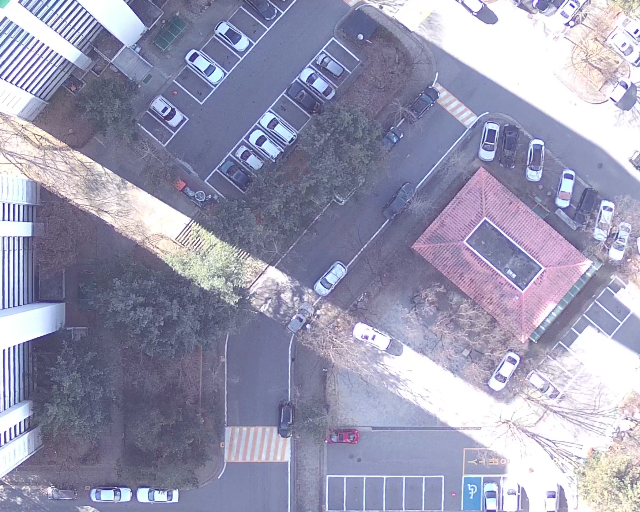

In [32]:
lab_img = Image.fromarray((rgb[2].numpy().transpose((1,2,0))*255).astype(np.uint8))
lab_img

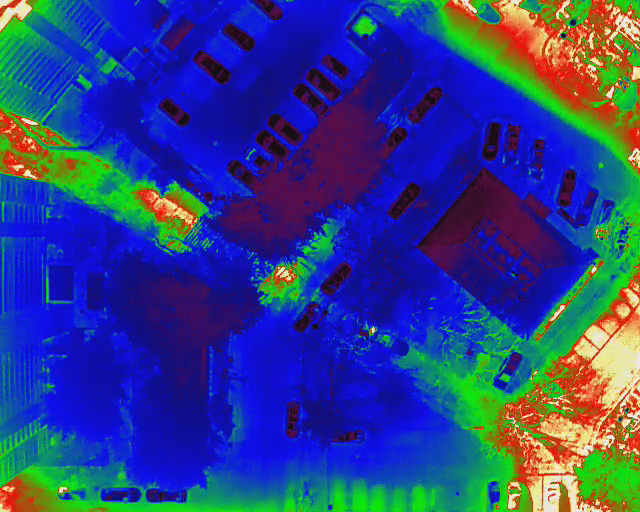

In [33]:
lab_img = Image.fromarray((thr[2].numpy().transpose((1,2,0))*255).astype(np.uint8))
lab_img

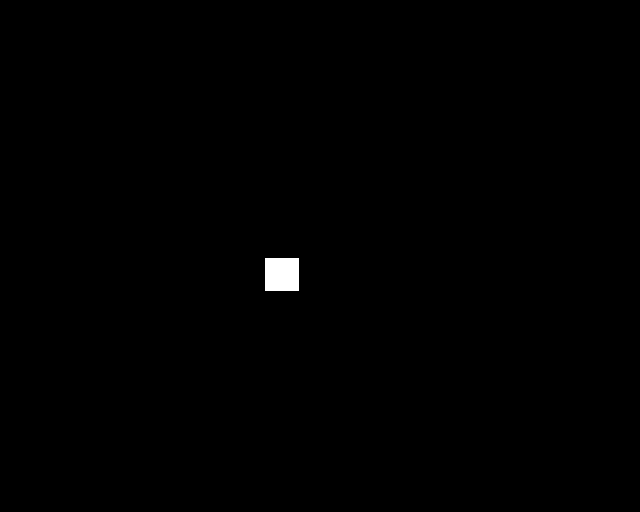

In [26]:
lab_img = Image.fromarray((lab[2].squeeze().numpy()*255).astype(np.uint8))
lab_img

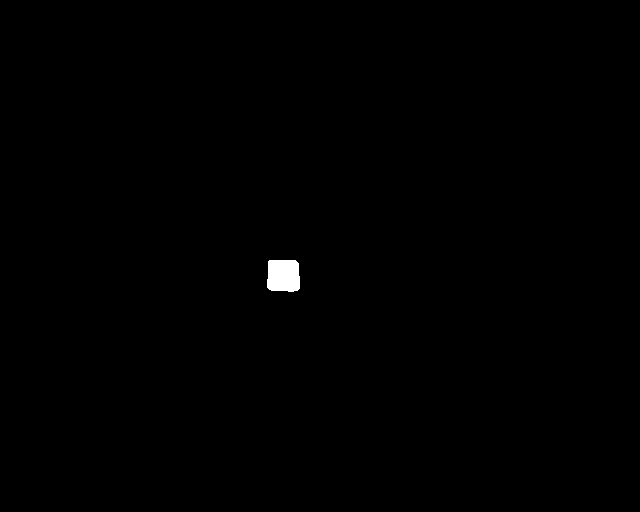

In [25]:
img = Image.fromarray(((F.sigmoid(pred).detach()[2].squeeze().numpy()>.5)*255).astype(np.uint8))
img